In [25]:
import tensorflow as tf
import cv2
import numpy as np

In [26]:
import matplotlib.pyplot as plt

parameters

In [27]:
learning_rate = .1

tv_beta = 3
l1_coeff = 0.01
tv_coeff = 0.2

max_iterations = 500

load model

In [28]:
model = tf.keras.applications.VGG19(weights='imagenet')
model.trainable = False
# model input space: 224,224,3

In [15]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
#model.trainable = False
# model.evaluate()

#for p in model.features.parameters():
#    p.requires_grad = False
#for p in model.classifier.parameters():
#    p.requires_grad = False

load image

In [29]:
# pytorch version
original_img = cv2.imread('/home/student/PycharmProjects/tf2_meaningful_perturbation/examples/hopper.jpg', 1)
#original_img = cv2.imread('/home/student/PycharmProjects/tf2_meaningful_perturbation/examples/YellowLabradorLooking_new.jpg', 1)
#original_img = cv2.imread('/home/student/PycharmProjects/tf2_meaningful_perturbation/examples/coffee.jpg', 1)
#original_img = cv2.imread('/home/student/PycharmProjects/pytorch_perturbation/pytorch-explain-black-box/examples/flute.jpg', 1)
original_img = cv2.resize(original_img, (224, 224))

img = np.float32(original_img) / 255

In [6]:
img.shape

(224, 224, 3)

In [30]:
blurred_img1 = cv2.GaussianBlur(img, (11, 11), 5)
blurred_img2 = np.float32(cv2.medianBlur(original_img, 11))/255
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2

mask_init = np.ones((28, 28), dtype = np.float32)

In [8]:
img = tf.io.read_file('/home/student/PycharmProjects/tf2_meaningful_perturbation/examples/YellowLabradorLooking_new.jpg')
img = tf.image.decode_image(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img,(224,224))

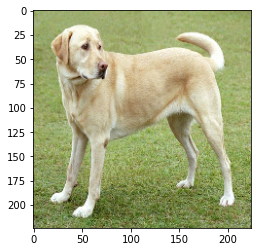

In [54]:
plt.imshow(img)
plt.show()

preprocess image

In [31]:
def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]
    
    preprocessed_img = img.copy()[:,:,::-1]
    for i in range(3):
        preprocessed_img[:,:,i] = preprocessed_img[:,:,i]-means[i]
        preprocessed_img[:,:,i] = preprocessed_img[:,:,i]/stds[i]
        #mean = preprocessed_img[:,:,i].mean()
        #preprocessed_img[:,:,i] = preprocessed_img[:,:,i]-mean
        #std = preprocessed_img[:,:,i].std()
        #preprocessed_img[:,:,i] = preprocessed_img[:,:,i]/std
    #preprocessed_img = np.ascontiguousarray(preprocess_image, dtype=np.float32)
    preprocessed_img_tensor = tf.convert_to_tensor(preprocessed_img)
    preprocessed_img_tensor = tf.expand_dims(preprocessed_img_tensor, 0)
    return preprocessed_img_tensor

In [32]:
def np_to_tensor(img):
    if len(img.shape)<3:
        output = np.float32([img])
    else:
        output = img
    output = tf.convert_to_tensor(output)
    print(output.shape)
    output = tf.expand_dims(output,3)
    print(output.shape)
    return output

In [33]:
def tv_norm(inputmask, tv_beta):
    img = inputmask[0,:,:,0]
    row_grad = tf.pow(tf.reduce_mean(tf.abs((img[:-1,:] - img[1:,:]))), tv_beta)
    col_grad = tf.pow(tf.reduce_mean(tf.abs((img[:,:-1] - img[:,1:]))), tv_beta)
    sum_grad = row_grad + col_grad
    return sum_grad

In [34]:
img = preprocess_image(img)
blurred_img = preprocess_image(blurred_img2)

In [35]:
mask = np.float32([mask_init])
mask = tf.convert_to_tensor(mask)
mask = tf.expand_dims(mask,3)
mask = tf.Variable(mask, trainable=True, name = 'mask')

In [36]:
upsample = tf.keras.layers.UpSampling2D(size=(8,8), interpolation='bilinear')

In [37]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate) 
# torch: Adam([mask], lr)

In [38]:
#target = tf.nn.softmax(model(img))
target = model(img)

In [39]:
category = np.argmax(target)
category

669

start for loop

In [16]:
upsampled_mask = upsample(mask)
upsampled_mask = tf.tile(upsampled_mask, multiples=(1,1,1,3))

In [17]:
perturbated_input = tf.math.multiply(img, upsampled_mask) + tf.math.multiply(blurred_img, 1-upsampled_mask)

In [18]:
noise = np.zeros((224,224,3), dtype=np.float32)
cv2.randn(noise, 0, 0.2)
noise = np.float32([noise])
noise = tf.convert_to_tensor(noise)

In [19]:
perturbated_input = perturbated_input + noise
perturbated_input.shape

TensorShape([1, 224, 224, 3])

In [30]:
outputs = model(perturbated_input)
#outputs = tf.nn.softmax(model(perturbated_input))
outputs.shape

TensorShape([1, 1000])

In [ ]:
loss = l1_coeff*tf.reduce_mean(tf.abs(1-mask)) + tv_coeff*tv_norm(mask, tv_beta) + outputs[0, category]
# l1_coeff: lasso regression (shrinks less important features to zero)
# total variation regularization
# 

In [ ]:
tf.GradientTape() # loss.backward()
minimize() # optimizer.step()

In [26]:
with tf.GradientTape() as tape:
    outputs = model(perturbated_input)
    l1 = l1_coeff*tf.reduce_mean(tf.abs(1-mask))
    print(l1)
    l2 = tv_coeff*tv_norm(mask, tv_beta)
    print(l2)
    l3 = outputs[0, category]
    print(l3)
    loss = l1 + l2 + l3
    #tape.watch(img)
    #loss = l1_coeff*tf.reduce_mean(tf.abs(1-mask)) + tv_coeff*tv_norm(mask, tv_beta) + outputs[0, category]
loss

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.07579846, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.07579846>

In [ ]:
grads = tape.gradient(loss, model.trainable_variables) # equal to loss.backward ??

In [ ]:
optimizer.apply_gradients(zip(grads, model.trainable_weights))

In [ ]:
tf.clip_by_value(mask, clip_value_min=0, clip_value_max=1)

save

In [ ]:
upsampled_mask = upsample(mask)
upsampled_mask.shape

In [ ]:
mask = np.array(upsampled_mask[0])
mask.shape

In [ ]:
mask = (mask - np.min(mask)) / np.max(mask)
mask = 1-mask

In [ ]:
heatmap = cv2.applyColorMap(np.uint8(225*mask), cv2.COLORMAP_JET)

In [ ]:
heatmap = np.float32(heatmap)/255
cam = 1.0*heatmap + np.float32(original_img)/225
cam = cam/np.max(cam)

In [ ]:
img = np.float32(original_img) / 255
perturbated = np.multiply(1-mask, original_img) + np.multiply(mask, blurred_img_numpy)

In [ ]:
cv2.imwrite('perturbated.png', np.uint8(255*perturbated))
cv2.imwrite('heatmap.png', np.uint8(255*heatmap))
cv2.imwrite('mask.png', np.uint8(255*mask))
cv2.imwrite('cam.png', np.uint8(255*cam))

# Save parameters from for loop

In [40]:
l1_ar = []
l2_ar = []
l3_ar = []
app_mask = []
app_ups_mask = []

In [41]:
for i in range(10):
    upsampled_mask = upsample(mask)
    upsampled_mask = tf.tile(upsampled_mask, multiples=(1,1,1,3))
    
    perturbated_input = tf.math.multiply(img, upsampled_mask) + tf.math.multiply(blurred_img, 1-upsampled_mask)
    
    noise = np.zeros((224,224,3), dtype=np.float32)
    cv2.randn(noise, 0, 0.2)
    noise = np.float32([noise])
    noise = tf.convert_to_tensor(noise)
    
    perturbated_input = perturbated_input + noise
    
    outputs = tf.nn.softmax(model(perturbated_input))
    
    with tf.GradientTape() as tape:
        tape.watch(mask)
        l1 = l1_coeff*tf.reduce_mean(tf.abs(1-mask))
        l2 = tv_coeff*tv_norm(mask, tv_beta)
        l3 = outputs[0, category]
        loss = l1 + l2 + l3
    
    l1_ar.append(l1)
    l2_ar.append(l2)
    l3_ar.append(l3)
    
    grads = tape.gradient(loss, [mask])
    optimizer.apply_gradients(zip(grads, [mask]))
    tf.clip_by_value(mask, clip_value_min=0, clip_value_max=1)     
    
    app_mask.append(mask)
    app_ups_mask.append(upsampled_mask)

look at tape

In [43]:
[var.name for var in tape.watched_variables()]

['mask:0']

Plot loss

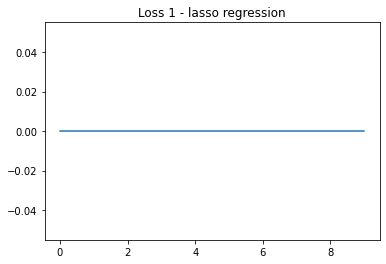

In [18]:
plt.plot(l1_ar)
plt.title('Loss 1 - lasso regression')
plt.show()

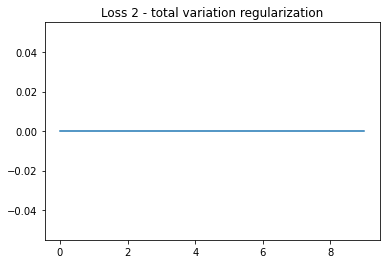

In [19]:
plt.plot(l2_ar)
plt.title('Loss 2 - total variation regularization')
plt.show()

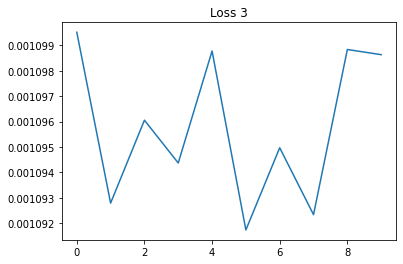

In [20]:
plt.plot(l3_ar)
plt.title('Loss 3')
plt.show()

Plot masks

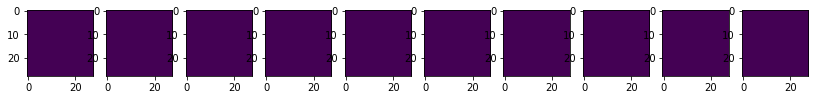

In [21]:
fig, ax = plt.subplots(1,10, figsize=(14,8))
for i in range(len(app_mask)):
    ax[i].imshow(app_mask[i][0])
plt.show()

Plot upsampled masks

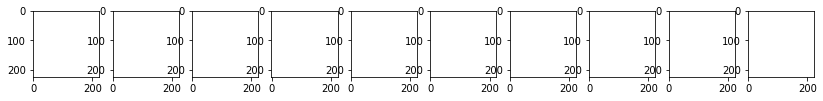

In [22]:
fig, ax = plt.subplots(1,10, figsize=(14,8))
for i in range(len(app_ups_mask)):
    ax[i].imshow(app_ups_mask[i][0])
plt.show()

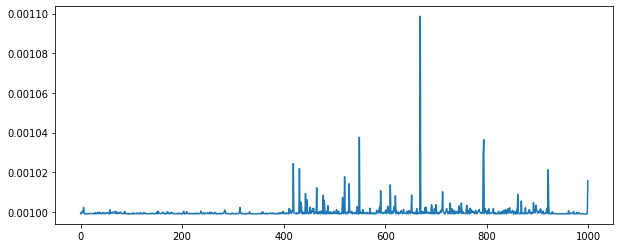

In [23]:
plt.figure(figsize=(10,4))
plt.plot(outputs[0])
plt.show()

In [34]:
outputs[0,category]

<tf.Tensor: shape=(), dtype=float32, numpy=0.0010838971>

In [32]:
category

178

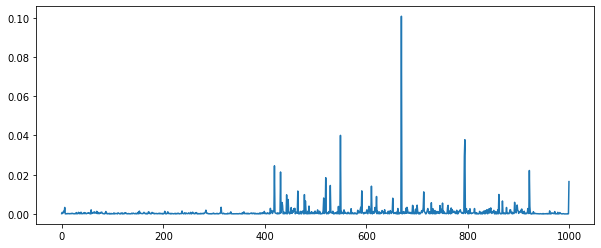

In [24]:
plt.figure(figsize=(10,4))
plt.plot(target[0])
plt.show()

In [33]:
tf.keras.applications.vgg19.decode_predictions(target.numpy())[0]

[('n02092339', 'Weimaraner', 0.07898188),
 ('n02099849', 'Chesapeake_Bay_retriever', 0.0623852),
 ('n02091134', 'whippet', 0.053787734),
 ('n02099712', 'Labrador_retriever', 0.045003526),
 ('n02109047', 'Great_Dane', 0.03900163)]

In [ ]:
category

In [67]:
img = img[tf.newaxis,:]
print(img.shape)
prediction_probabilities = model(img)

(1, 224, 224, 3)


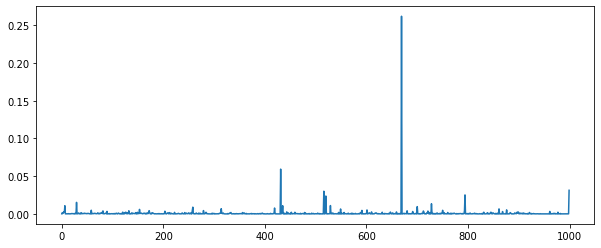

In [68]:
plt.figure(figsize=(10,4))
plt.plot(prediction_probabilities[0])
plt.show()

In [70]:
tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())

[[('n03788365', 'mosquito_net', 0.2619544),
  ('n02804414', 'bassinet', 0.0593793),
  ('n15075141', 'toilet_tissue', 0.03129466),
  ('n03125729', 'cradle', 0.030092336),
  ('n04209239', 'shower_curtain', 0.025180906)]]

## import image

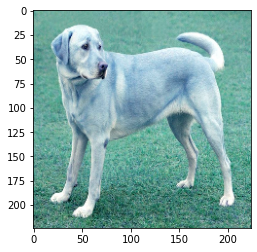

In [43]:
plt.imshow(original_img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


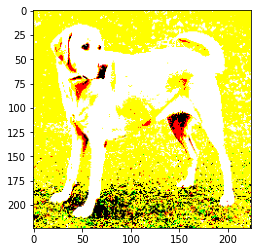

In [44]:
processed_original_img = tf.keras.applications.imagenet_utils.preprocess_input(original_img)
plt.imshow(processed_original_img)
plt.show()

In [ ]:
preprocessed_img.shape

In [ ]:
perturbated_input

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.fromarray(perturbated_input))
plt.show()

# Upsample

mask: (1,28,28,1) --> (1,224,224,1)

In [8]:
upsample = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear', data_format='channels_first')

In [4]:
x = np.arange(1,5, dtype=np.float32).reshape(1,1,2,2)
x

array([[[[1., 2.],
         [3., 4.]]]], dtype=float32)

In [9]:
y = upsample(x)
y

<tf.Tensor: shape=(1, 1, 4, 4), dtype=float32, numpy=
array([[[[1.  , 1.25, 1.75, 2.  ],
         [1.5 , 1.75, 2.25, 2.5 ],
         [2.5 , 2.75, 3.25, 3.5 ],
         [3.  , 3.25, 3.75, 4.  ]]]], dtype=float32)>

In [10]:
y.shape

TensorShape([1, 1, 4, 4])

In [34]:
original_img = cv2.imread('/home/student/PycharmProjects/tf2_meaningful_perturbation/examples/coffee.jpg', 1)

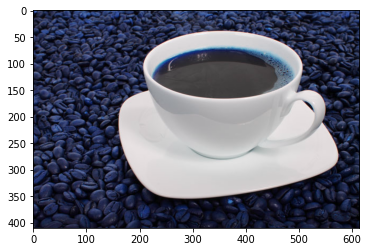

In [40]:
plt.imshow(original_img)
plt.show()

In [23]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')


90112/83281 [================================] - 0s 1us/step


In [24]:
content_path

'/home/student/.keras/datasets/YellowLabradorLooking_new.jpg'